In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")
tags    = pd.read_csv("tags.csv")


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
# Converting timestamp to date and time
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s")
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [7]:
# removing duplicates

ratings.drop_duplicates(inplace=True)
tags.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)


In [8]:
# checking missing values

ratings.isna().sum()
movies.isna().sum()
tags.isna().sum()


userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [9]:
# converting genres to tokens easier TF IDF application later

movies["genres"] = movies["genres"].str.replace("|", " ", regex=False)


In [10]:
tags["tag"] = tags["tag"].str.lower().str.strip()


In [11]:
import re
tags["tag"] = tags["tag"].apply(lambda x: re.sub(r"[^a-zA-Z0-9 ]", "", x))


In [12]:
# removed rare tags eg. tags removed with frequency less than 5 times
tag_counts = tags["tag"].value_counts()
common_tags = tag_counts[tag_counts >= 5].index
tags = tags[tags["tag"].isin(common_tags)]


In [13]:
# grouping tags for same movie so combining them 

movie_tags = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x))
movie_tags = movie_tags.reset_index()

# merging with movies

movies = movies.merge(movie_tags, on="movieId", how="left")

movies.columns




Index(['movieId', 'title', 'genres', 'tag'], dtype='object')

In [14]:
# dealing with missing values in newly created tag column for different movies
movies["tag"] = movies["tag"].fillna("")

In [15]:
movies.isna().sum()

movieId    0
title      0
genres     0
tag        0
dtype: int64

In [16]:
movies["content"] = movies["genres"] + " " + movies["tag"]



This new column created will be the input for TF IDF recommender

In [17]:
movies.head()

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy,Adventure Children Fantasy fantasy
2,3,Grumpier Old Men (1995),Comedy Romance,,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake


In [18]:
# removing users who have performed less than 5 ratings for better Collaborative Filtering

user_counts = ratings["userId"].value_counts()
active_users = user_counts[user_counts >= 5].index
ratings = ratings[ratings["userId"].isin(active_users)]


In [19]:
# removing least popular movies with less than 5 ratings

movie_counts = ratings["movieId"].value_counts()
popular_movies = movie_counts[movie_counts >= 5].index
ratings = ratings[ratings["movieId"].isin(popular_movies)]


In [20]:
user_item_matrix = ratings.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)


In [21]:
ratings = ratings.sort_values("timestamp")

train = ratings.groupby("userId").head(-1)
test  = ratings.groupby("userId").tail(1)


In [22]:
user_ids = train["userId"].unique()
movie_ids = train["movieId"].unique()

user_map = {id:i for i,id in enumerate(user_ids)}
movie_map = {id:i for i,id in enumerate(movie_ids)}


#### Result of Data Preprocessing

Dataset and their uses
1. train - for CF SVD training later
2. test - for evaluation
3. movies["content"] - TF IDF content model
4. user_item_matrix - for similarity models

### Exploratory Data Analysis

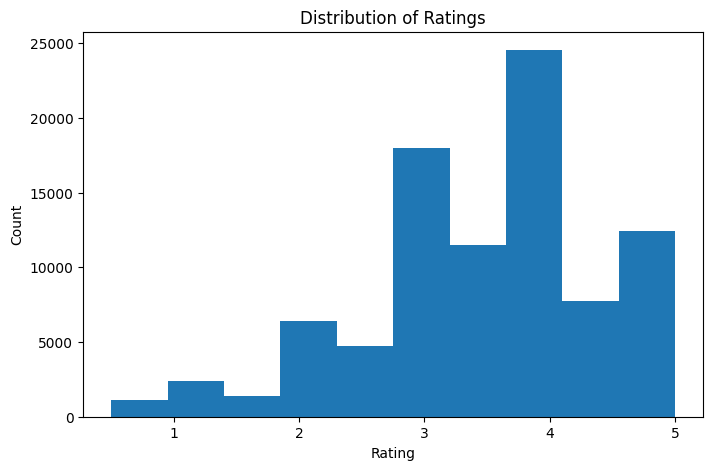

<Figure size 640x480 with 0 Axes>

In [25]:
# Rating Distribution Chart

plt.figure(figsize=(8,5))
plt.hist(ratings["rating"], bins=10)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

plt.savefig(r"C:\Users\Aditya Singh\AI ML\BrainDead\reports\eda_images")



The dataset is positively skewed, indicating users mostly rate movies they like. This introduces rating bias and motivates ranking-based evaluation instead of pure rating prediction.

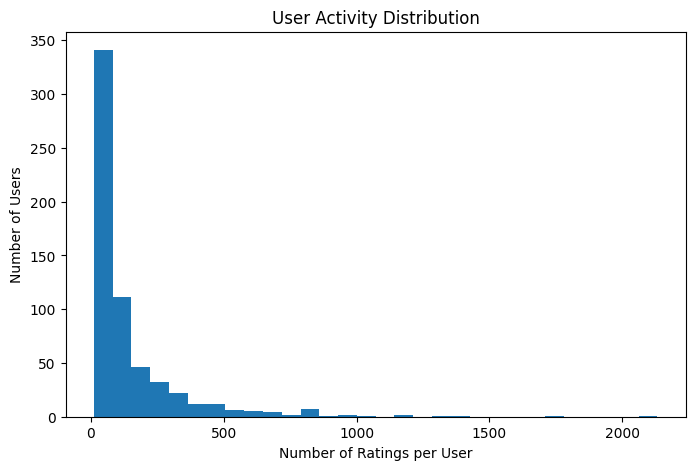

In [ ]:
# User Activity Histogram

user_activity = ratings.groupby("userId").size()

plt.figure(figsize=(8,5))
plt.hist(user_activity, bins=30)
plt.title("User Activity Distribution")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.show()


Most users rate few movies,
Few power users rate hundreds

In [ ]:
# counting rating per movies
movie_popularity = ratings.groupby("movieId").size()


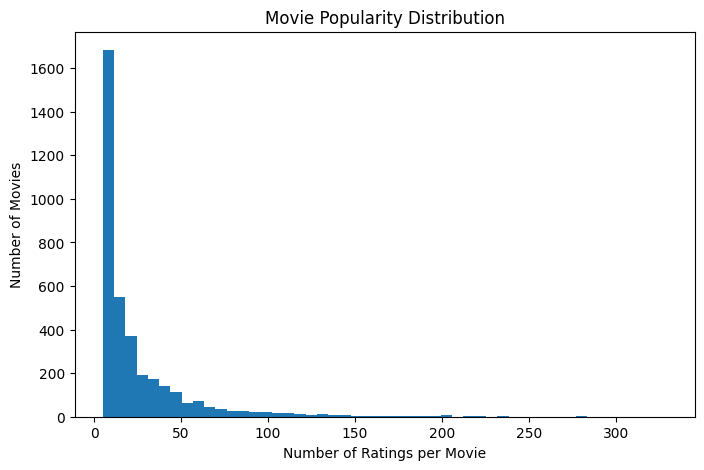

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(movie_popularity, bins=50)
plt.title("Movie Popularity Distribution")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.show()

The dataset follows a long-tail distribution where a small number of popular movies dominate interactions. This motivates diversity and novelty optimization.This connects to the diversity section later.  
Few movies have many ratings (blockbusters)

In [ ]:
# Most Popular Genres

from collections import Counter

genres = movies["genres"].str.split(" ")
all_genres = [g for sublist in genres for g in sublist]

genre_counts = Counter(all_genres)


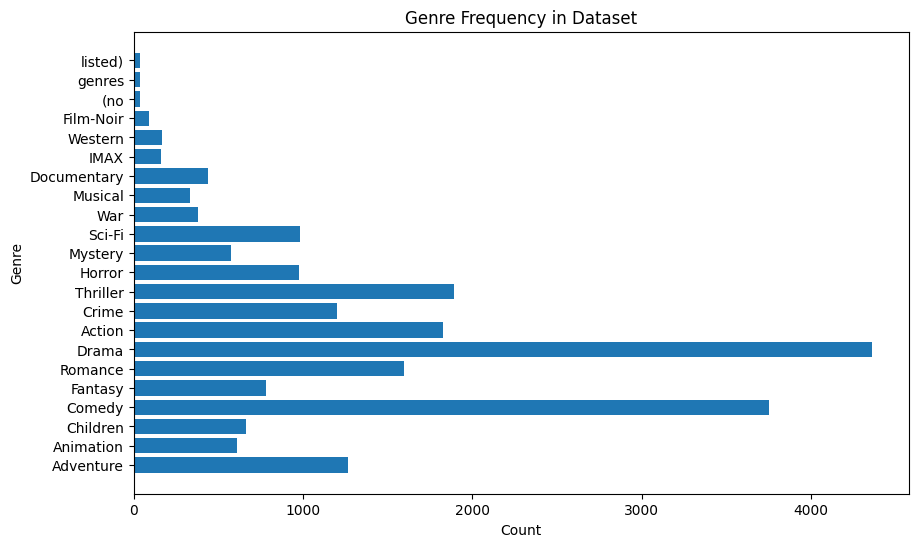

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(list(genre_counts.keys()), list(genre_counts.values()))
plt.title("Genre Frequency in Dataset")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

Drama & Comedy dominate MovieLens  
Some genres are underrepresented  
Genre imbalance may bias recommendations toward popular genres.  


In [ ]:
# Genres vs Average Rating

merged = ratings.merge(movies, on="movieId")    #merged ratings with movies

genre_ratings = merged.copy()
genre_ratings["genres"] = genre_ratings["genres"].str.split(" ")
genre_ratings = genre_ratings.explode("genres")


# computing mean rating per genre

avg_genre_rating = genre_ratings.groupby("genres")["rating"].mean().sort_values()



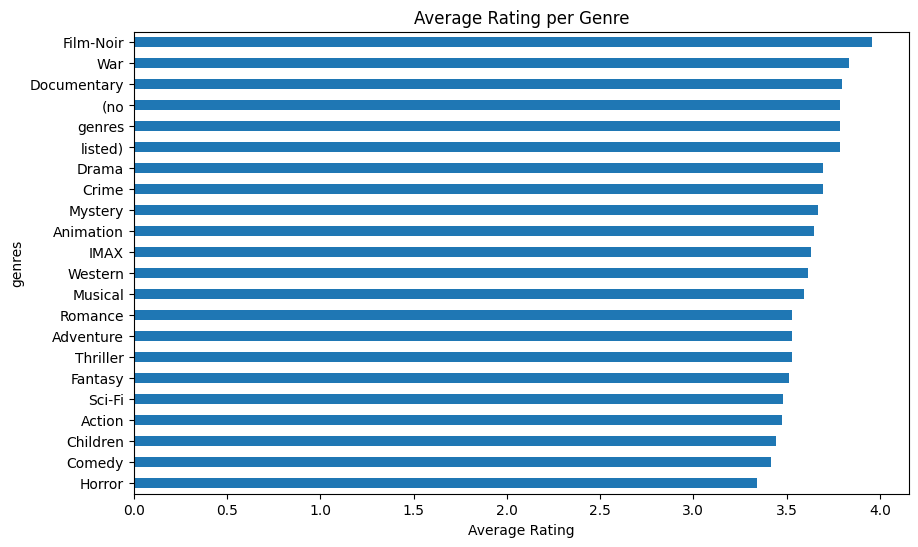

In [ ]:
plt.figure(figsize=(10,6))
avg_genre_rating.plot(kind="barh")
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.show()


Certain niche genres receive higher ratings despite lower popularity, indicating opportunities for novel recommendations.

In [ ]:
# Ratings over time

ratings["year"] = ratings["timestamp"].dt.year
ratings_per_year = ratings.groupby("year").size()


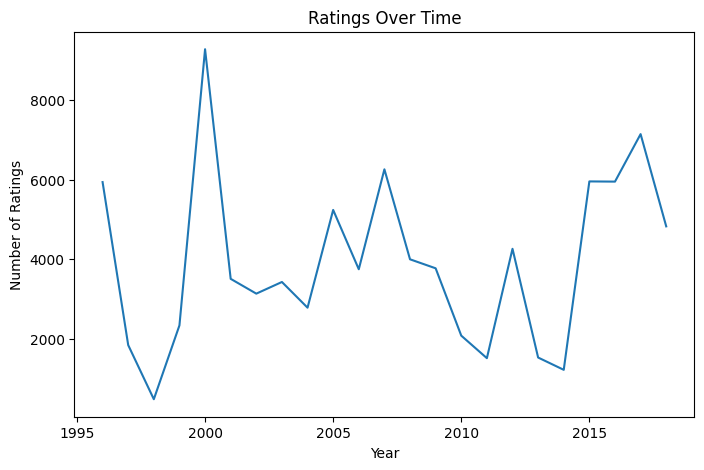

In [ ]:
plt.figure(figsize=(8,5))
ratings_per_year.plot()
plt.title("Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.show()


Rating activity increases over time, reflecting growing user engagement.